## Speaker Gender Classification

**Table of content**

* [Data preparation](#I)
* [Exploratory Data Analysis](#II)
* [Classification models](#III)
* [Results](#IV)
* [Discussion](#V)

In [1]:
import os
import soundfile
import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import python_speech_features as mfcc

import warnings
warnings.filterwarnings("ignore")

<a id='I'></a>
### 1. Data preparation

In this section, we load and prepare our dataset which consists of several audio speech samples. We also map each signal to the gender of the speaker

**Obtain _speaker-id <-> gender_ mapping**

In [2]:
id_gender = pd.read_csv('id_gender.csv')

In [3]:
id_gender.head()

,ID,SEX,SUBSET,MINUTES,NAME
0,14,F,train-clean-360,25.03,Kristin LeMoine
1,16,F,train-clean-360,25.11,Alys AtteWater
2,17,M,train-clean-360,25.04,Gord Mackenzie
3,19,F,train-clean-100,25.19,Kara Shallenberg
4,20,F,train-other-500,30.07,Gesine


In [4]:
id_gender['SUBSET'].unique()

array([' train-clean-360  ', ' train-clean-100  ', ' train-other-500  ',
       ' test-clean       ', ' dev-clean        ', ' dev-other        ',
       ' test-other       '], dtype=object)

We are only interested in the `ID` and `SEX` columns, for which `SUBSET = dev-clean`, since this is the dataset we are using.

In [5]:
id_gender_mapping = id_gender[ id_gender['SUBSET']==' dev-clean        ' ][['ID', 'SEX']]

In [6]:
id_gender_mapping.head()

,ID,SEX
46,84,F
93,174,M
135,251,M
200,422,M
279,652,M


In [7]:
id_gender_mapping['SEX'].value_counts()

 F     20
 M     20
Name: SEX, dtype: int64

**40 different speakers**

*Note the that the classes are perfectly balanced, accuracy can eventually be used as a metric to evalutate the gender classification models*

In [8]:
id_gender_mapping['SEX'].unique()

array([' F ', ' M '], dtype=object)

Transform gender to integer labels; M to 1 and F to 0 

In [9]:
id_gender_mapping['SEX'] = id_gender_mapping['SEX'].apply(lambda x: 1 if x == ' M ' else 0)

In [10]:
id_gender_mapping.head()

,ID,SEX
46,84,0
93,174,1
135,251,1
200,422,1
279,652,1


**Collect audio samples and compute MFCC features**

We will use the `python_speech_features` library to extract the MFCC features. <br>
Let's define a function that compute such features.

In [11]:
def compute_MFCC(signal, fs, numcep=13): 
    '''
    Compute MFCC features of an audio signal
    
    Parameters
    ----------
    audio : audio sample from a speaker 
    fs : sampling frequency
    
    '''
    features = mfcc.mfcc(signal, fs, 0.025, 0.01, numcep, appendEnergy = False)
    features = np.mean(features, axis=0).reshape(1,-1)
    return features

In [12]:
path_to_audio_files = 'LibriSpeech/dev-clean/'

In [13]:
# Create dataset where each row represents the MFCC features of a frame of 25 milliseconds 
dataset = np.ndarray(shape=(0,13))
gender_labels = np.ndarray(shape=(0,1))
files = []

# Do a recursive walk on all the audio files
for filename in tqdm(glob.iglob(path_to_audio_files + '**/*', recursive=True)):
    if filename.endswith('.flac'):
        files.append(filename)
        # Read audio signal and compute MFCC features
        sig, fs = soundfile.read(filename)
        features = compute_MFCC(sig, fs)
        
        # Append MFCC features to our dataset and update accordingly the gender label for all the new frames
        dataset = np.append(dataset, features, axis=0)
        speaker_id = filename.split('/dev-clean/')[1].split('/')[0]
        gender = id_gender_mapping[ id_gender_mapping['ID'] == int(speaker_id) ]['SEX'].iloc[0]
        gender_labels= np.append(gender_labels, np.array(gender).reshape(-1,1), axis=0)


2937it [01:07, 43.55it/s]


<a id='II'></a>
### 2. Exploratory Data Analysis

We plot the distribution of our features and look for outliers and skewed distribution 

In [14]:
data = pd.DataFrame(dataset)

In [15]:
data.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-49.125403,-10.091915,9.374611,-10.275918,-2.644703,-6.208837,-1.778341,-2.062584,1.374386,-1.307706,6.341380,-1.892872,-5.731740
1,-47.963830,-8.454820,7.956802,-9.742774,5.220691,-5.988113,-8.208070,-4.825172,2.080790,1.548718,2.757104,-3.491100,-4.118049
2,-47.424011,-12.474357,9.821865,-7.298854,2.101969,-8.395803,-6.894354,-4.336211,-2.189679,-0.245318,2.402032,-1.897523,-5.324680
3,-48.870806,-8.927204,6.481015,-10.442381,5.132314,-9.987909,-8.287478,-5.194423,3.776423,-1.489403,2.437860,0.011792,-4.288302
4,-49.199102,-11.581737,8.645419,-10.532126,2.749861,-5.947502,-8.672104,-1.572971,0.717981,0.838450,-0.148657,-3.150131,-5.015686
5,-48.814983,-11.374386,8.889162,-10.260627,4.602313,-6.330814,-8.456474,-0.341044,-1.366233,3.637368,3.168515,-2.757039,-6.173920
6,-51.009535,-11.068821,10.605551,-7.383021,1.732760,-7.116057,-2.787882,-5.870913,0.814872,-2.097247,3.154060,1.782600,-4.304279
7,-51.803200,-10.951631,5.480317,-6.842229,2.203396,-9.655953,-5.019144,2.190848,2.885147,-2.032022,2.257996,-2.149336,-5.255550
8,-53.965434,-13.391438,4.930931,-7.390614,3.937692,-7.008029,-4.139418,0.564412,3.022716,2.789478,1.193799,-2.924420,-5.877539
9,-48.279649,-9.885267,7.829816,-5.148685,1.869652,-8.132949,-6.969120,-2.935658,1.492169,-1.030416,2.001677,1.242098,-6.839486


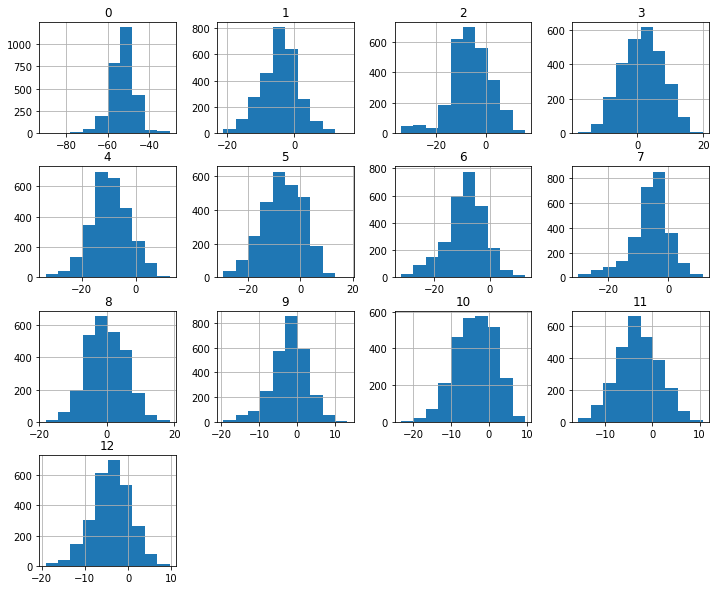

In [16]:
h = data.hist(figsize=(12,10))

_We observe no skewed distribution nor outliers_

**Diagonal correlation matrix**

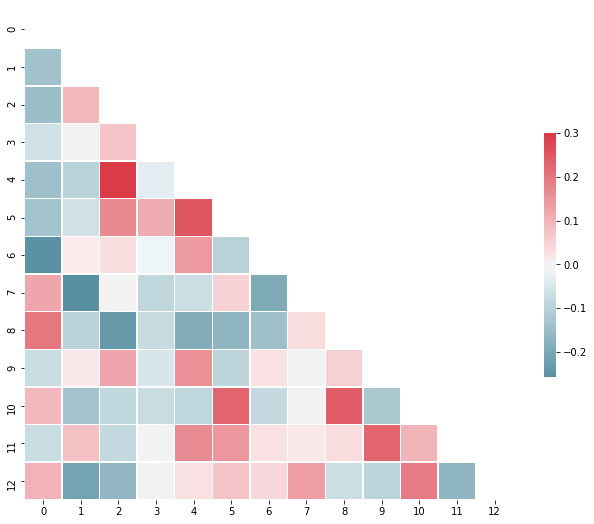

In [17]:
corr = data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

h = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We can observe that the MFCC featues aren't highly correlated between each other since the correlation varies between -0.3 and 0.3.

In [18]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000,2703.000000
mean,-52.721955,-4.292902,-6.196046,1.708362,-9.396211,-6.736553,-8.775772,-5.819784,-0.190100,-1.845782,-3.707681,-2.959319,-3.890427
std,5.817396,5.447871,7.980351,6.113372,7.159874,7.763244,6.952503,6.380153,5.620162,4.602001,5.270595,4.425160,4.405548
min,-89.771212,-21.211687,-34.034999,-17.771753,-33.343967,-29.458764,-31.885599,-29.827393,-18.162847,-19.460987,-23.268991,-15.738485,-19.077982
25%,-55.964016,-7.690567,-11.041131,-2.728162,-13.751970,-12.143940,-12.681330,-8.755979,-4.136205,-4.332543,-7.443887,-5.894402,-6.650850
50%,-52.364871,-3.971205,-6.080278,1.892077,-9.668392,-6.462809,-8.257554,-5.001823,-0.561427,-1.605278,-3.518618,-3.018763,-3.748618
75%,-49.100194,-0.925524,-0.806583,6.132425,-4.641206,-0.730575,-4.109227,-1.979423,3.923777,1.066446,0.316355,0.095166,-0.958700
max,-30.158965,15.924678,15.630593,19.817739,12.658457,17.995143,12.717234,11.518480,18.637855,13.351553,9.566763,10.678672,9.625411


In [19]:
data.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
dtype: object

All features are continuous, thus there is no need to perform one hot encoding, nor feature hashing.

In [20]:
data.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

There are no missing values in our dataset 

<a id='III'></a>
### 3. Classification models

We evalutate in this section several classification models. We will use **accuracy** as a performance metric, since the classes (Male/Female) are balanced.

* [Gaussian Naive Bayes](#1)
* [Gradient Boosting Trees](#2)
* [Random Forest](#3)
* [Logistic Regression](#4)
* [Feed Forward Neural Network](#5)
* [1D - Convolutional Neural Network](#6)
* [2D - Convolutional Neural Network](#7)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.utils import check_X_y
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [22]:
dataset.shape

(2703, 13)

In [23]:
gender_labels.shape

(2703, 1)

In [24]:
gender_labels.sum()

1329.0

Our dataset consists of **2703 speech audio signals**. 1329 of which corresponds to male speech (*49 %*).

Split data into training set and test set

In [25]:
seed = 1
X_train, X_test, y_train, y_test = train_test_split(dataset, gender_labels, test_size=0.2, random_state=seed, stratify=gender_labels)

Input validation

In [26]:
X_train, y_train = check_X_y(X=X_train, y=y_train)
X_test, y_test = check_X_y(X=X_test, y=y_test)

We will tune eventual hyperparameters using a validation set

In [27]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = seed, stratify = y_train)

<a id='1'></a>
#### 3.1 Gaussian Naive Bayes

In [28]:
# Define a gaussian naive bayes classifier pipeline

estimators = []
estimators.append(('standardizer', StandardScaler()))
estimators.append(('gnb', GaussianNB()))

pipeline_gnb = Pipeline(estimators)

pipeline_gnb.fit(X_train, y_train)
y_pred = pipeline_gnb.predict(X_test)

score = accuracy_score(y_test, y_pred)
print('Gaussian Naive Bayes accuracy on test set: {}'.format(score))

Gaussian Naive Bayes accuracy on test set: 0.833641404805915


<a id='2'></a>
#### 3.2 Gradient Boosting Trees

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

# Define a gradient boosting tree classifier pipeline
estimators = []
estimators.append(('gb_clf', GradientBoostingClassifier()))

pipeline = Pipeline(estimators)
pipeline.set_params(gb_clf__random_state = seed)
    
# Finding best value of n_estimators using validation set
scores = []
NSs = []
for NS in tqdm([int(i) for i in np.linspace(10, 1000, 20)]):
    pipeline.set_params(gb_clf__n_estimators = NS) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict(X_train_val)
    scores.append(accuracy_score (y_train_val, y_train_pred))
    NSs.append(NS)

best_NS = NSs[scores.index(max(scores))]
print ('best NS = %d with accuracy : %2.4f' %(best_NS, max(scores)))

# Performance of the tuned model on test set
pipeline.set_params(gb_clf__n_estimators = best_NS)
pipeline.fit(X_train,y_train)
y_pred_gb = pipeline.predict(X_test)
score = accuracy_score(y_test, y_pred_gb)
print ('GB classifier accuracy on test set: %2.4f' %score)

100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


best NS = 791 with accuracy : 0.9677
GB classifier accuracy on test set: 0.9797


<a id='3'></a>
#### 3.3 Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Define a random forest classifier pipeline
estimators = []
estimators.append(('rf_clf', RandomForestClassifier()))
pipeline_rf = Pipeline(estimators)
pipeline_rf.set_params(rf_clf__random_state = seed)
    
# Finding best value of n_estimators using validation set
scores = []
NSs = []
for NS in tqdm([int(i) for i in np.linspace(10, 100, 20)]):
    pipeline_rf.set_params(rf_clf__n_estimators = NS) 
    pipeline_rf.fit(X_train_train,y_train_train)
    y_train_pred = pipeline_rf.predict(X_train_val)
    scores.append(accuracy_score(y_train_val, y_train_pred))
    NSs.append(NS)

best_NS = NSs[scores.index(max(scores))]
print ('best NS = %d with accuracy : %2.4f' %(best_NS, max(scores)))

# Performance of the tuned model on test set
pipeline_rf.set_params(rf_clf__n_estimators = best_NS)
pipeline_rf.fit(X_train,y_train)
y_pred_rf = pipeline_rf.predict(X_test)
score = accuracy_score(y_test, y_pred_rf)
print ('Random forest classifer accuracy on test set : %2.4f' %score)

100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


best NS = 62 with accuracy : 0.9723
Random forest classifer accuracy on test set : 0.9704


**Note that there is no need to standardize nor normalize features for decision tree based models, since there are based on a collection of partition rules.** 

<a id='4'></a>
#### 3.4 Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

#  features and classifier in a single pipeline
estimators = []
estimators.append(('minmax', MinMaxScaler(feature_range=(0,1))))
estimators.append(('lr_clf', LogisticRegression(random_state = seed)))
pipeline_lr = Pipeline(estimators)
pipeline_lr.set_params(lr_clf__penalty='l2')

# Finding best value of C using validation set
scores = []
Cs = []
for C in tqdm(np.logspace(0, 2.5, 100)):
    pipeline_lr.set_params(lr_clf__C=C) 
    pipeline_lr.fit(X_train_train,y_train_train)
    y_train_pred = pipeline_lr.predict(X_train_val)
    scores.append(accuracy_score(y_train_val, y_train_pred))
    Cs.append(C)

best_C_l2 = Cs[scores.index(max(scores))]
print ('best C = %2.4f with accuracy : %2.4f' %(best_C_l2, max(scores)))

# Performance of the tuned model on test set
pipeline_lr.set_params(lr_clf__C=best_C_l2)
pipeline_lr.fit(X_train,y_train)
y_pred_lrRl2 = pipeline_lr.predict(X_test)
score = accuracy_score(y_test, y_pred_lrRl2)
print ('l2-Logistic regression classifer accuracy on test set : %2.6f' %score)

100%|██████████| 100/100 [00:00<00:00, 154.67it/s]

best C = 10.2353 with accuracy : 0.8383
l2-Logistic regression classifer accuracy on test set : 0.868762


<a id='5'></a>
#### 3.5 Feed Forward Neural Network

In [32]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from keras.callbacks import Callback, EarlyStopping

Using TensorFlow backend.


In [33]:
# build neural network model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=dataset.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [34]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                448       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(X_train, y_train, batch_size=20, epochs=17, verbose=1, validation_split=0.2)

Train on 1729 samples, validate on 433 samples
Epoch 1/17
1729/1729 [==============================] - 1s 292us/step - loss: 0.6583 - acc: 0.7340 - val_loss: 0.3236 - val_acc: 0.8499
Epoch 2/17
1729/1729 [==============================] - 0s 69us/step - loss: 0.2991 - acc: 0.8699 - val_loss: 0.2326 - val_acc: 0.9076
Epoch 3/17
1729/1729 [==============================] - 0s 70us/step - loss: 0.2529 - acc: 0.8994 - val_loss: 0.2073 - val_acc: 0.9192
Epoch 4/17
1729/1729 [==============================] - 0s 69us/step - loss: 0.2103 - acc: 0.9161 - val_loss: 0.1804 - val_acc: 0.9215
Epoch 5/17
1729/1729 [==============================] - 0s 68us/step - loss: 0.1824 - acc: 0.9283 - val_loss: 0.1558 - val_acc: 0.9423
Epoch 6/17
1729/1729 [==============================] - 0s 70us/step - loss: 0.1717 - acc: 0.9329 - val_loss: 0.1488 - val_acc: 0.9446
Epoch 7/17
1729/1729 [==============================] - 0s 70us/step - loss: 0.1543 - acc: 0.9456 - val_loss: 0.1481 - val_acc: 0.9400
Epoch 8

In [36]:
y_pred_ffnn = model.predict_classes(X_test)
score = accuracy_score(y_test, y_pred_ffnn)
print ('Feed Forward Neural Network accuracy on test set : %2.6f' %score)

Feed Forward Neural Network accuracy on test set : 0.953789


<a id='6'></a>
#### 3.6 1D - Convolutional Neural Network

In this section we implement a standard 1D CNN that consistst of one layer of several 1D convolutions (32 filters each of size 10), a Pooling layer, a Dropout layer and finally a Fully Connected layer.

In [37]:
from keras.layers import Dense, Conv1D, GlobalMaxPool1D, Dropout

In [38]:
def create_cnn_model():
    model = Sequential()
    model.add(Conv1D(32,10, activation='relu', input_shape=(13, 1)))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.1))
    model.add(Dense(1,activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [39]:
num_samples, num_features = dataset.shape
X_train, X_test, y_train, y_test = train_test_split(dataset.reshape(num_samples, num_features,1) , gender_labels, test_size=0.2, random_state=seed, stratify=gender_labels)

In [40]:
model = create_cnn_model()
model.fit(X_train, y_train, batch_size=20, epochs=15, verbose=1, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 4, 32)             352       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
Train on 1729 samples, validate on 433 samples
Epoch 1/15
1729/1729 [==============================] - 1s 490us/step - loss: 0.9004 - acc: 0.6032 - val_loss: 0.3340 - val_acc: 0.8522
Epoch 2/15
1729/1729 [==============================] - 0s 142us/step - loss: 0.4663 - a

In [41]:
y_pred_1dcnn = model.predict_classes(X_test)
score = accuracy_score(y_test, y_pred_1dcnn)
print ('1D CNN accuracy on test set : %2.6f' %score)

1D CNN accuracy on test set : 0.946396


<a id='7'></a>
#### 3.7 2D - Convolutional Neural Network

We implement in this a section a CNN to classify spectrograms as coming from a Male or Female. Spectrograms represent the variation of frequency over time. We know that women have a high pitched voice compared to men. Thus when looking at a spectrogram of woman we should be able to see more component on high frequencies compared to a man's spectrogram. This is the observation we would hope our CNN model could learn, to classify correctly the images.

In [42]:
from keras.layers import Conv2D, Flatten
import librosa.display

**Compute spectrograms**

In [43]:
spectrograms = []
gender_labels = np.ndarray(shape=(0,1))

for filename in tqdm(files):
    signal, fs = soundfile.read(filename)
    S = librosa.feature.melspectrogram(signal, sr=fs)
    spectrograms.append(librosa.power_to_db(S,ref=np.max))

    speaker_id = filename.split('/dev-clean/')[1].split('/')[0]
    gender = id_gender_mapping[ id_gender_mapping['ID'] == int(speaker_id) ]['SEX'].iloc[0]
    gender_labels= np.append(gender_labels, np.array(gender).reshape(-1,1), axis=0)

100%|██████████| 2703/2703 [00:58<00:00, 46.47it/s]


Keep only spectrograms with enough samples (sufficiently long audio samples). We zip up everything to keep track of the mapping gender label <-> spectrogram.

In [44]:
cut_off_t = 120
new_spectrograms = zip(spectrograms, gender_labels)
new_spectrograms = list(filter(lambda x: x[0].shape[1] > cut_off_t, new_spectrograms ))

In [45]:
images, gender_labels = zip(*new_spectrograms) 
images = list(images)
gender_labels = list(gender_labels)

In [46]:
len(images)

1998

In [47]:
len(gender_labels)

1998

In [48]:
# Get an example of a man's spectrogram
male_spectrogram = images[gender_labels.index(1)] 

**Example of a man's spectrogram**

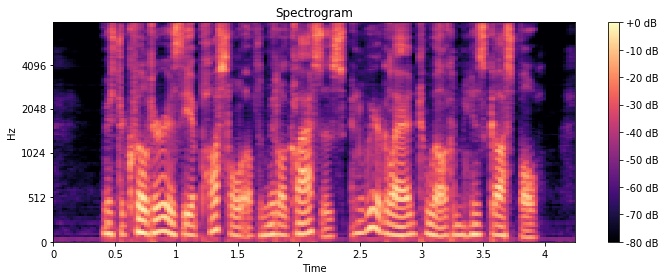

In [49]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(male_spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()

Note that _images_ doesn't have the same shape, however our CNN model expects to have images with a fixed dimension. We will crop all images to the smallest shape (time axis).
Also, all images have the same length on the frequency axis

In [50]:
min_t = min(images, key=lambda x: x.shape[1]).shape[1]

In [51]:
images = list(map(lambda x: x[:,-min_t:].reshape(x.shape[0], min_t, 1), images))

Sanity check

In [52]:
len(list(filter(lambda x: x.shape[1] != min_t, images )))

0

In [53]:
images[0].shape

(128, 121, 1)

We will use a simple CNN network that consists of 2 convolutional layers followed by fully connected layer.

In [54]:
def create_model_cnn():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(128, 121, 1)))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [55]:
X_train, X_test, y_train, y_test = train_test_split(np.array(images), np.array(gender_labels), test_size=0.2, random_state=seed, stratify=gender_labels)

In [56]:
model = create_model_cnn()
model.fit(X_train, y_train, batch_size=20, epochs=2, verbose=1, validation_split=0.2)

Train on 1278 samples, validate on 320 samples
Epoch 1/2
1278/1278 [==============================] - 96s 75ms/step - loss: 8.1181 - acc: 0.4930 - val_loss: 7.2028 - val_acc: 0.5531
Epoch 2/2
1278/1278 [==============================] - 94s 73ms/step - loss: 8.1473 - acc: 0.4945 - val_loss: 7.2028 - val_acc: 0.5531


In [57]:
y_pred = model.predict_classes(np.array(X_test))
score = accuracy_score(y_test, y_pred)
print ('2D CNN accuracy on test set : %2.6f' %score)

2D CNN accuracy on test set : 0.507500


<a id='IV'></a>
### 4. Results

In [58]:
%%html
<style>
table {float:left}
</style>

|               Model               | Accuracy Score |
|:---------------------------------:|:--------------:|
|      Gradient Boosting Trees      |     0.9797     |
|           Random Forest           |     0.9704     |
|    Feed Forward Neural Network    |     0.9538     |
| 1D - Convolutional Neural Network |     0.9464     |
|        Logistic Regression        |     0.8688     |
|        Gaussian Naive Bayes       |     0.8336     |
| 2D - Convolutional Neural Network |     0.5075     |


<a id='V'></a>
### 5. Discussion

* We observe that the 2D CNN model perform the worst. Even random guessing could beat the model. This is because the axes of spectrograms don't carry the same meaning as regular images of cats or dogs for instance.
* Decision tree based models performs the best. This is because among the MFCC features some are highly related to the gender of the speaker hence making the decision rules straightforward and robust.
* The 1D CNN and FFNN have great performances and eventually with hyperparameters tuning (i.e experimenting with several architectures) can perform better than the decision tree based models.
* Further work to improve the performances could be to implement a stacking of the best models. This stacking could be linear or even decision tree based itself.
* We didn't use feature engineering nor feature reduction techniques in this assignment since the MFCC features represents already a great feature space for our task. Indeed, they capture all the necessary propreties of speech signal to perform an accurate prediction on the gender of the speaker.